# Introduction

Visual arts is an effective mean of story-telling. It is expressive in nature and easy to forge a connection to the audience, and thus is commonly used as a mean of persuasion by injecting pathos in its role. In the field of conservation, visual arts are crucial in raising public awareness in endangered species and habitat protection. The modern approach of "Artivism", is using visual arts to create change in culture and shift in public opinion. One of the successful cases of "Artivism" is the documentary film by Shawn Heinrichs, a cinematographer focusing on filming sharks and rays slaughtering. His documentaries, played to the locals in West Papua, Indonesia, successfully transitioned a hunting culture into eco-tourism, and eventually managed to create the first marine "*Provinsi Konservasi*", or conservation province, in the world. A wide variety of visual arts can fulfill the purpose of artivism. The idea of this project is to provide style-mapping to images using deep learning to create novelty, bestow new layers of meanings, and elicit empathy.

A Generative Adversarial Network (GAN) is a generative network that is first introduced in 2014 by Ian Goodfellow, et al ([DOI: arXiv:1406.2661](https://arxiv.org/abs/1406.2661)). The generator generates simple random variables, and transforms them into complex ones as output. The generator is then paired with a discrimator which tries to distinguish the generator's output from the samples in the target domain. The generator and discriminator are then trained adversarially to enhance their performance until the equilibrium where the generator can completely deceive the discriminator.

The idea of CycleGAN is developed in 2017 by Jun-Yan Zhu, et al. in their research paper *Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks* ([DOI: arXiv:1703.10593](https://arxiv.org/abs/1703.10593)). In the cycle-consistent adversarial networks, two generators, *AtoB* and *BtoA*, map domain A to domain B, and domain B to domain A, respectively. Both generators are paired with a discrimator, and are trained adversarially to generate realistic outputs. Moreover, outputs from generator *AtoB* are fed into *BtoA* to map the output back to domain A. This "cycled" output is then compared with domain A by the discriminator, and the difference ("cycle loss") is used to punish the networks. This design enables the generative neural nets to only apply styles/target features to images without changing the main features of the input.

In this project, a CycleGAN is built in Keras to take winter landscape photos as input, and output a summer-styled version of them, and vice versa. The networks are trained on approximately 1000 summer photos and another 1000 winter photos scraped from the internet, where all photo samples are resized to 256 x 256. The network is trained using a Tesla V100 GPU on Vast.ai. 

For future, the two desired domains, summer and winter, are abbreviated as A and B, respectively.

# Data Preprocessing

First, import and load datasets.

In [1]:
import os

import numpy as np
from matplotlib import pyplot as plt

from keras.preprocessing.image import img_to_array, load_img
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from keras.initializers import RandomNormal
from keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
from keras import Model
from keras.optimizers import Adam

import random

def load_dir(src):
    photos = []
    
    for pic in os.listdir(src):
        pic = load_img(src + '/' + pic, target_size=(256, 256))
        pic = img_to_array(pic)
        photos.append(pic)
    
    return np.asarray(photos)

trainA = load_dir('resizedSeasonDataset/trainA')
testA = load_dir('resizedSeasonDataset/testA')
trainB = load_dir('resizedSeasonDataset/trainB')
testB = load_dir('resizedSeasonDataset/testB')

A = np.vstack((trainA, testA))
B = np.vstack((trainB, testB))
print('Shape of A: ', A.shape)
print('Shape of B: ', B.shape)

np.savez_compressed('resizedSeasonDataset/dataAB.npz', A, B)
print('Data saved to resizedSeasonDataset/dataAB.npz')

Shape of A:  (1096, 256, 256, 3)
Shape of B:  (1090, 256, 256, 3)
Data saved to resizedSeasonDataset/dataAB.npz


In the following, the samples from two domains are briefly examined. It can be observed that the summer samples are more colourful in style, comparing to the majority of whiteness in winter samples. The variety in the colour feature, as a hypothetic note, would create inconsistent style mapping from winter domain to summer domain, and if time permits, the summer photos could have been carefully prepared with a consistent style (e.g. green). 

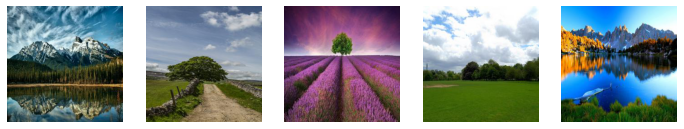

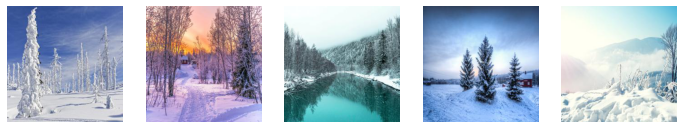

In [2]:
dataset = np.load('resizedSeasonDataset/dataAB.npz')
A, B = dataset['arr_0'], dataset['arr_1']

plt.figure(figsize=(12, 5))
for i in range (5):
    plt.subplot(2, 5, 1 + i)
    plt.axis('off')
    plt.imshow(A[i].astype('uint8'))
plt.show()

plt.figure(figsize=(12, 5))
for i in range (5):
    plt.subplot(2, 5, 1 + i)
    plt.axis('off')
    plt.imshow(B[i].astype('uint8'))
plt.show()

# Models: Generators and Discriminators

The discriminator is a PatchGAN 70x70 discriminator built using convolutional and LeakyReLU layers, based on the paper. The optimization uses Mean Squared Error (MSE). Moreover, the author recommands to use loss_weight = 0.5 because it is desirable to make the updates of the discriminator slower than the generator during training for more robust generators.

The generator is an encoder-decoder model. Besides the downsampling and upsampling, the model uses ResNet blocks to interpret the downsampled/encoded data. Matching the research paper, 9 such ResNet layers are applied, and the filter size of the convolutional layers in ResNet blocks are all set to be 3x3.

In [3]:
def discriminator(shape):
    
    init = RandomNormal(stddev=0.02)
    
    # Input
    inputLayer = Input(shape=shape)
    
    # Convolution layers: 64, 128, 256, 512, 512
    model = Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding='same',
                  kernel_initializer=init)(inputLayer)
    model = LeakyReLU(alpha=0.2)(model)
    
    model = Conv2D(filters=128, kernel_size=(4, 4), strides=(2, 2), padding='same',
                  kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = LeakyReLU(alpha=0.2)(model)
    
    model = Conv2D(filters=256, kernel_size=(4, 4), strides=(2, 2), padding='same',
                  kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = LeakyReLU(alpha=0.2)(model)
    
    model = Conv2D(filters=512, kernel_size=(4, 4), strides=(2, 2), padding='same',
                  kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = LeakyReLU(alpha=0.2)(model)
    
    model = Conv2D(filters=512, kernel_size=(4, 4), strides=(1, 1), padding='same',
                  kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = LeakyReLU(alpha=0.2)(model)
    
    # output
    output = Conv2D(filters=1, kernel_size=(4, 4), strides=(1, 1), padding='same', 
                   kernel_initializer=init)(model)
    model = Model(inputLayer, output)
    
    # Compile
    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
    
    return model

In [4]:
def resnetGen(n_filters, inputLayer):
    init = RandomNormal(stddev=0.02)
    
    # convolutional layer 1
    block = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same',
                  kernel_initializer=init)(inputLayer)
    block = InstanceNormalization(axis=-1)(block)
    block = Activation('relu')(block)
    
    # convolutional layer 2
    block = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same',
                  kernel_initializer=init)(block)
    block = InstanceNormalization(axis=-1)(block)

    # output
    block = Concatenate()([block, inputLayer])
    return block

def generator(shape):
    """
    According to the article, choose the network with 9 residual blocks
    c7s1-64, d128, d256, r256x9, u128, u64, c7s1-3
    """
    init = RandomNormal(stddev=0.02)
    
    # Input
    inputLayer = Input(shape=shape)
    
    # c7s1-64
    model = Conv2D(filters=64, kernel_size=(7, 7), padding='same',
                  kernel_initializer=init)(inputLayer)
    model = InstanceNormalization(axis=-1)(model)
    model = Activation('relu')(model)
    
    # d128
    model = Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                  kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = Activation('relu')(model)
    
    # d256
    model = Conv2D(filters=256, kernel_size=(3, 3), strides=(2, 2), padding='same',
                  kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = Activation('relu')(model)
    
    # R256x9
    for i in range(9):
        model = resnetGen(256, model)
        
    # u128
    model = Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=(2, 2), padding='same',
                           kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = Activation('relu')(model)
    
    # u64
    model = Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=(2, 2), padding='same',
                           kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    model = Activation('relu')(model)
    
    # c7s1-3
    model = Conv2D(filters=3, kernel_size=(7, 7), strides=(1, 1), padding='same',
                           kernel_initializer=init)(model)
    model = InstanceNormalization(axis=-1)(model)
    
    # output
    output = Activation('tanh')(model)
    model = Model(inputLayer, output)
    return model

# Loss

Define four losses:
* __Adversial Loss__: Feed an image from A to G1, and compare the loss of the output against target domain B.
* __Identity Loss__: Feed an image from B to G1, and compare the loss of the output against ifself (target domain B).
* __Forward Cycle Loss__: Feed an image from A to G1, then feed the output to G2, and compare the loss of the final output against source domain A.
* __Backward Cycle Loss__: Feed an image from B to G2, then feed the output to G1, and compare the loss of the final output against target domain B.

Matching the research paper, the total loss is a weigted average of the four losses above, with weight distributed 1, 5, 10, 10, respectively, and that they are defined as mean squared error, mean absolute error, mean absolute error, and mean absolute error, respectively.

In [5]:
def compositeModel(gen1, dis1, gen2, shape):
    
    gen1.trainable = True
    dis1.trainable = False
    gen2.trainable = False
    
    # Adversial
    inputLayer = Input(shape=shape)
    gen1Out = gen1(inputLayer)
    dis1Out = dis1(gen1Out)
    
    # Identity
    identityInputLayer = Input(shape=shape)
    identityGen1Out = gen1(identityInputLayer)
    
    # Forward Cycle
    forwardOut = gen2(gen1Out)
    
    # Backward Cycle
    gen2Out = gen2(identityInputLayer)
    backwardOut = gen1(gen2Out)
    
    # Define model
    model = Model([inputLayer, identityInputLayer], 
                 [dis1Out, identityGen1Out, forwardOut, backwardOut])
    model.compile(loss=['mse', 'mae', 'mae', 'mae'],
                 loss_weights=[1, 5, 10, 10],
                 optimizer=Adam(lr=0.0002, beta_1=0.5))
    
    return model

Each composite model is used to train only one generator (as above, only for the input "gen1" generator), and thus in the end two composite models are needed, one for each generator.

# Load Data and Batch

The getRealSample function randomly selects images from one domain, and generates the target labels for the patchGAN discriminator model (ones). The output of the patchGAN will be a 256 = 16x16x1 activation map. The getFakeSample function uses the generator to generate a fake sample, but the target labels are set to fake (zeros).

In [6]:
def loadSamples(src):
    #load
    dataset = np.load(src)
    A, B = dataset['arr_0'], dataset['arr_1']
    
    # Normalize and return
    A = (A - 127.5) / 127.5
    B = (B - 127.5) / 127.5
    return [A, B]

def getRealSample(dataset, sampleSize, shape):
    
    indices = np.random.randint(0, dataset.shape[0], sampleSize)
    X = dataset[indices]
    y = np.ones((sampleSize, shape, shape, 1))
    
    return X, y

def getFakeSample(gen, dataset, shape):
    
    X = gen.predict(dataset)
    y = np.zeros((len(X), shape, shape, 1))
    
    return X, y

Typically, the loss of the GAN models does not converge. The only indication is that an equilibrium is reached between the generator and the discriminator. And thus, in every certain amount of epochs, the weights would have to be saved and used to train new images. 

In [30]:
def saveModel(step, gen1, gen2):
    gen1.save('gen1_{}saved.h5'.format(step+1))
    gen2.save('gen2_{}saved.h5'.format(step+1))

The viewGenerated function defined below demonstrates some generated translated images, and saves the plot.

In [31]:
def viewGenerated(step, gen, X_train, name):
    
    # Get a sample from a domain
    X_in, _ = getRealSample(X_train, 5, 0)
    
    # Translate using generator and normalize.
    X_out, _ = getFakeSample(gen, X_in, 0)
    X_in = (X_in + 1) / 2
    X_out = (X_out + 1) / 2
    
    # plot real
    plt.figure(figsize=(12, 5))
    for i in range(5):
        plt.subplot(2, 5, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i])
        
    # plot fake
    plt.figure(figsize=(12, 5))
    for i in range(5):
        plt.subplot(2, 5, 6 + i)
        plt.axis('off')
        plt.imshow(X_out[i])
        
    # Save plot
    plt.savefig('{0}StepGeneratedPlot({1}).png'.format(step + 1, name))
    plt.close()

In order to manage and monitor the learning/updating speed of the discriminator model, the paper's original author proposed the method of maintaining a pool of generated fake images for each discriminator. This is implemented as a pool of 50 fake images stored in a python list, and probabilistically either add a new fake image or replace one of the existing fake image in the list using the updatePool function below.

In [32]:
def updatePool(pool, imgs):
    
    selectedImgs = list()
    for img in imgs:
        
        # Adds to the pool if the pool is less than 50 imgs.
        if len(pool) < 50:
            pool.append(img)
            selectedImgs.append(img)
            
        # 50% of the remaining case, use the image but do not add to pool
        elif random.random() < 0.5:
            selectedImgs.append(img)
        
        # 50% of the remaining case, use the image and add to pool
        else:
            idx = np.random.randint(0, len(pool))
            selectedImgs.append(pool[idx])
            pool[idx] = img
        
    return np.asarray(selectedImgs)        

# Training

In the following, the training hyperparameters are set according to the paper. Specifically, the batchsize is set to 1, and the number of epochs is set to be 200. However, due to various constraints, the model is trained on only 30 epochs. 

First, a batch of real images are randomly selected from each domain, then they are used by the generators to generate the fake images. The fake images are used to update each discriminator's fake image pool. Next, both generators are updated via their respective composite model. Finally, each weighted average losses are used to update each generator and are reported.

In [33]:
def train(disA, disB, genA, genB, compA, compB, dataset):
    
    # Set up hyperparams and data structures
    BATCHSIZE = 1
    EPOCH = 30 # should be 200
    PATCH = disA.output_shape[1]
    trainA, trainB = dataset
    poolA, poolB = [], []
    BATCH_PER_EPOCH = int(len(trainA) / BATCHSIZE)
    STEPS = BATCH_PER_EPOCH * EPOCH
    
    print("Total steps: {}".format(STEPS))
    # train over epochs
    for i in range (STEPS):
        
        # Randomly select real samples
        X_realA, y_realA = getRealSample(trainA, BATCHSIZE, PATCH)
        X_realB, y_realB = getRealSample(trainB, BATCHSIZE, PATCH)
        
        # Use real samples to generate fake samples
        X_fakeA, y_fakeA = getFakeSample(genB, X_realB, PATCH)
        X_fakeB, y_fakeB = getFakeSample(genA, X_realA, PATCH)
        
        # update pool for each discriminator
        X_fakeA = updatePool(poolA, X_fakeA)
        X_fakeB = updatePool(poolB, X_fakeB)
        
        # update genB via composite model
        genBLoss, _,_,_,_ = compB.train_on_batch([X_realB, X_realA],
                                                [y_realA, X_realA, X_realB, X_realA])
        
        # update disA via the real/fake classification result
        disALoss1 = disA.train_on_batch(X_realA, y_realA)
        disALoss2 = disA.train_on_batch(X_fakeA, y_fakeA)
        
        # update genA via composite model
        genALoss, _,_,_,_ = compA.train_on_batch([X_realA, X_realB],
                                                [y_realB, X_realB, X_realA, X_realB])
        
        # update disB via the real/fake classification result
        disBLoss1 = disB.train_on_batch(X_realB, y_realB)
        disBLoss2 = disB.train_on_batch(X_fakeB, y_fakeB)
        
        # Summarize
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (
            i+1, disALoss1, disALoss2, disBLoss1, disBLoss2, genALoss, genBLoss))
        
        # Evaluate
        if (i + 1) % (BATCH_PER_EPOCH * 1) == 0:
            viewGenerated(i, genA, trainA, 'AtoB')
            viewGenerated(i, genB, trainB, 'BtoA')
        
        if (i + 1) % (BATCH_PER_EPOCH * 5) == 0:
            saveModel(i, genA, genB)

Now, load data and start training. The data is trained on a Tesla V100 GPU on Vast.ai. On the machine, the training speed is around 80 seconds per 100 steps, or 0.8s/step.

<img src="gpu.png">

Total steps: 32880
>1, dA[0.554,1.300] dB[0.594,1.809] g[17.106,18.077]
>2, dA[3.824,1.390] dB[5.443,1.301] g[17.912,18.418]
>3, dA[11.737,0.956] dB[8.010,1.535] g[23.230,19.280]
>4, dA[4.996,1.329] dB[2.669,4.955] g[18.507,18.362]
>5, dA[3.209,1.039] dB[1.781,2.037] g[18.304,17.500]
>6, dA[4.750,0.926] dB[1.757,4.372] g[21.767,17.445]
>7, dA[8.536,0.806] dB[0.973,3.814] g[20.899,15.737]
>8, dA[2.345,0.681] dB[3.521,2.237] g[21.668,15.176]
>9, dA[1.174,0.624] dB[2.910,1.385] g[15.637,14.221]
>10, dA[1.111,0.684] dB[1.024,1.180] g[14.357,12.179]
>11, dA[1.074,0.686] dB[2.214,1.961] g[13.004,11.082]
>12, dA[0.618,1.224] dB[1.587,1.786] g[12.706,12.317]
>13, dA[0.654,0.862] dB[0.991,1.019] g[15.361,14.618]
>14, dA[0.662,0.684] dB[0.850,0.614] g[11.804,11.353]
>15, dA[0.401,0.500] dB[0.713,0.336] g[10.954,11.902]
>16, dA[0.598,0.431] dB[0.525,0.533] g[11.981,12.213]
>17, dA[0.680,0.612] dB[0.404,0.415] g[12.762,12.942]
>18, dA[0.377,0.424] dB[0.392,0.351] g[13.199,12.399]
>19, dA[0.331,0.3

>156, dA[0.122,0.152] dB[0.183,0.131] g[7.783,6.956]
>157, dA[0.308,0.133] dB[0.117,0.216] g[5.835,6.373]
>158, dA[0.151,0.075] dB[0.122,0.273] g[6.974,7.246]
>159, dA[0.231,0.312] dB[0.072,0.215] g[5.354,6.338]
>160, dA[0.081,0.226] dB[0.299,0.033] g[6.421,6.854]
>161, dA[0.144,0.058] dB[0.101,0.169] g[6.659,8.517]
>162, dA[0.167,0.136] dB[0.219,0.127] g[7.829,8.455]
>163, dA[0.098,0.353] dB[0.286,0.187] g[7.058,6.134]
>164, dA[0.532,0.130] dB[0.065,0.238] g[8.102,9.762]
>165, dA[0.208,0.263] dB[0.256,0.252] g[7.775,8.606]
>166, dA[0.135,0.155] dB[0.295,0.120] g[5.884,5.791]
>167, dA[0.094,0.127] dB[0.149,0.205] g[8.700,8.104]
>168, dA[0.134,0.169] dB[0.320,0.127] g[7.082,6.774]
>169, dA[0.126,0.128] dB[0.169,0.136] g[6.584,6.718]
>170, dA[0.187,0.327] dB[0.210,0.352] g[5.102,4.990]
>171, dA[0.166,0.079] dB[0.093,0.051] g[5.285,6.253]
>172, dA[0.156,0.138] dB[0.132,0.305] g[6.275,7.103]
>173, dA[0.075,0.103] dB[0.160,0.114] g[8.172,8.011]
>174, dA[0.507,0.248] dB[0.144,0.182] g[7.021,

>311, dA[0.130,0.269] dB[0.136,0.313] g[5.347,5.608]
>312, dA[0.397,0.041] dB[0.044,0.088] g[4.182,5.254]
>313, dA[0.265,0.186] dB[0.213,0.233] g[5.718,6.283]
>314, dA[0.030,0.410] dB[0.161,0.086] g[7.852,6.660]
>315, dA[0.277,0.161] dB[0.336,0.240] g[9.379,8.489]
>316, dA[0.132,0.060] dB[0.079,0.125] g[6.295,7.405]
>317, dA[0.104,0.138] dB[0.143,0.098] g[8.523,9.220]
>318, dA[0.269,0.229] dB[0.080,0.278] g[7.640,8.894]
>319, dA[0.066,0.054] dB[0.175,0.131] g[6.673,7.765]
>320, dA[0.037,0.043] dB[0.144,0.236] g[6.176,6.181]
>321, dA[0.041,0.197] dB[0.130,0.067] g[5.238,5.125]
>322, dA[0.108,0.062] dB[0.210,0.131] g[5.414,5.518]
>323, dA[0.140,0.236] dB[0.238,0.174] g[6.839,6.935]
>324, dA[0.113,0.033] dB[0.265,0.342] g[5.959,6.658]
>325, dA[0.124,0.282] dB[0.064,0.214] g[6.009,6.969]
>326, dA[0.164,0.098] dB[0.364,0.051] g[6.915,7.083]
>327, dA[0.060,0.046] dB[0.176,0.166] g[6.179,7.182]
>328, dA[0.151,0.059] dB[0.066,0.189] g[5.021,6.354]
>329, dA[0.040,0.155] dB[0.198,0.077] g[5.304,

>466, dA[0.122,0.173] dB[0.134,0.160] g[6.574,6.509]
>467, dA[0.240,0.075] dB[0.383,0.082] g[5.433,6.851]
>468, dA[0.236,0.358] dB[0.181,0.384] g[8.973,8.764]
>469, dA[0.148,0.030] dB[0.121,0.091] g[3.749,4.895]
>470, dA[0.051,0.272] dB[0.261,0.192] g[6.546,6.563]
>471, dA[0.116,0.157] dB[0.044,0.098] g[9.946,9.892]
>472, dA[0.361,0.125] dB[0.365,0.203] g[6.873,7.852]
>473, dA[0.079,0.140] dB[0.167,0.152] g[6.979,7.053]
>474, dA[0.040,0.038] dB[0.182,0.184] g[7.008,7.601]
>475, dA[0.056,0.399] dB[0.163,0.055] g[6.808,7.316]
>476, dA[0.180,0.081] dB[0.217,0.127] g[5.576,6.174]
>477, dA[0.222,0.065] dB[0.086,0.185] g[5.780,6.995]
>478, dA[0.091,0.127] dB[0.146,0.069] g[3.737,4.159]
>479, dA[0.045,0.110] dB[0.179,0.149] g[5.130,5.581]
>480, dA[0.092,0.247] dB[0.080,0.293] g[6.327,6.687]
>481, dA[0.189,0.101] dB[0.179,0.084] g[5.475,6.906]
>482, dA[0.274,0.227] dB[0.250,0.207] g[5.497,6.258]
>483, dA[0.118,0.162] dB[0.071,0.180] g[7.425,7.466]
>484, dA[0.182,0.109] dB[0.182,0.067] g[6.247,

>621, dA[0.188,0.055] dB[0.036,0.077] g[5.367,6.122]
>622, dA[0.043,0.175] dB[0.092,0.039] g[5.332,5.070]
>623, dA[0.028,0.102] dB[0.087,0.060] g[6.148,6.501]
>624, dA[0.211,0.041] dB[0.128,0.116] g[5.112,5.998]
>625, dA[0.104,0.165] dB[0.182,0.250] g[5.512,6.557]
>626, dA[0.085,0.199] dB[0.210,0.269] g[4.904,5.126]
>627, dA[0.115,0.039] dB[0.295,0.182] g[3.129,3.464]
>628, dA[0.150,0.109] dB[0.119,0.136] g[4.730,5.491]
>629, dA[0.046,0.208] dB[0.062,0.129] g[5.415,4.748]
>630, dA[0.130,0.026] dB[0.185,0.127] g[4.951,5.304]
>631, dA[0.049,0.233] dB[0.251,0.075] g[8.906,9.992]
>632, dA[0.280,0.063] dB[0.049,0.054] g[7.027,9.074]
>633, dA[0.277,0.280] dB[0.375,0.201] g[4.668,4.723]
>634, dA[0.131,0.071] dB[0.038,0.047] g[5.435,6.289]
>635, dA[0.095,0.292] dB[0.200,0.106] g[5.555,5.838]
>636, dA[0.166,0.051] dB[0.016,0.148] g[6.550,7.239]
>637, dA[0.189,0.368] dB[0.261,0.206] g[6.493,7.942]
>638, dA[0.066,0.084] dB[0.242,0.109] g[6.403,5.887]
>639, dA[0.148,0.126] dB[0.251,0.261] g[4.896,

>776, dA[0.199,0.118] dB[0.104,0.108] g[5.654,5.770]
>777, dA[0.024,0.073] dB[0.032,0.007] g[5.747,6.223]
>778, dA[0.103,0.048] dB[0.365,0.236] g[5.155,5.469]
>779, dA[0.058,0.083] dB[0.049,0.207] g[8.509,8.741]
>780, dA[0.025,0.124] dB[0.266,0.146] g[5.512,5.926]
>781, dA[0.267,0.159] dB[0.283,0.189] g[4.950,5.957]
>782, dA[0.046,0.232] dB[0.062,0.107] g[4.234,4.213]
>783, dA[0.347,0.065] dB[0.165,0.083] g[6.018,7.017]
>784, dA[0.053,0.063] dB[0.035,0.046] g[7.036,6.829]
>785, dA[0.018,0.106] dB[0.191,0.173] g[5.681,6.532]
>786, dA[0.587,0.115] dB[0.167,0.264] g[5.876,6.809]
>787, dA[0.119,0.306] dB[0.266,0.113] g[4.895,4.742]
>788, dA[0.182,0.190] dB[0.054,0.081] g[8.274,7.697]
>789, dA[0.138,0.116] dB[0.429,0.268] g[10.210,9.457]
>790, dA[0.242,0.135] dB[0.147,0.137] g[5.427,5.334]
>791, dA[0.137,0.109] dB[0.275,0.043] g[5.196,5.429]
>792, dA[0.052,0.127] dB[0.170,0.150] g[6.583,6.574]
>793, dA[0.013,0.022] dB[0.159,0.081] g[7.618,8.737]
>794, dA[0.066,0.117] dB[0.156,0.155] g[7.403

>931, dA[0.139,0.110] dB[0.030,0.088] g[5.154,5.223]
>932, dA[0.039,0.142] dB[0.035,0.027] g[5.289,5.100]
>933, dA[0.171,0.160] dB[0.379,0.124] g[6.699,6.777]
>934, dA[0.105,0.083] dB[0.160,0.213] g[5.790,6.200]
>935, dA[0.075,0.042] dB[0.075,0.040] g[4.813,5.774]
>936, dA[0.058,0.102] dB[0.043,0.021] g[7.960,8.763]
>937, dA[0.232,0.104] dB[0.399,0.178] g[4.533,4.238]
>938, dA[0.030,0.153] dB[0.265,0.148] g[6.591,6.613]
>939, dA[0.595,0.139] dB[0.168,0.267] g[4.279,5.863]
>940, dA[0.217,0.238] dB[0.055,0.113] g[4.128,4.958]
>941, dA[0.105,0.118] dB[0.239,0.171] g[3.829,4.102]
>942, dA[0.146,0.100] dB[0.177,0.129] g[4.132,4.199]
>943, dA[0.055,0.057] dB[0.133,0.130] g[4.515,4.669]
>944, dA[0.044,0.144] dB[0.078,0.185] g[4.608,5.084]
>945, dA[0.117,0.158] dB[0.018,0.016] g[9.414,9.190]
>946, dA[0.139,0.052] dB[0.061,0.126] g[4.002,5.001]
>947, dA[0.048,0.244] dB[0.050,0.006] g[5.089,4.933]
>948, dA[0.753,0.137] dB[0.023,0.018] g[4.593,6.641]
>949, dA[0.019,0.091] dB[0.201,0.124] g[8.887,

>1084, dA[0.163,0.047] dB[0.227,0.122] g[5.150,6.369]
>1085, dA[0.053,0.234] dB[0.070,0.140] g[5.365,5.499]
>1086, dA[0.434,0.140] dB[0.260,0.299] g[3.870,4.833]
>1087, dA[0.067,0.126] dB[0.116,0.126] g[8.965,7.662]
>1088, dA[0.184,0.069] dB[0.059,0.039] g[6.685,6.068]
>1089, dA[0.095,0.299] dB[0.404,0.053] g[6.221,5.687]
>1090, dA[0.062,0.059] dB[0.129,0.105] g[5.496,6.842]
>1091, dA[0.142,0.030] dB[0.054,0.296] g[6.112,6.735]
>1092, dA[0.022,0.033] dB[0.277,0.100] g[7.867,8.487]
>1093, dA[0.268,0.114] dB[0.072,0.079] g[6.934,7.914]
>1094, dA[0.102,0.085] dB[0.349,0.124] g[6.349,7.001]
>1095, dA[0.095,0.219] dB[0.029,0.184] g[5.112,5.688]
>1096, dA[0.075,0.075] dB[0.194,0.129] g[5.650,5.916]
>1097, dA[0.061,0.092] dB[0.252,0.136] g[5.751,5.989]
>1098, dA[0.168,0.116] dB[0.209,0.145] g[3.972,4.864]
>1099, dA[0.019,0.050] dB[0.124,0.191] g[3.929,5.591]
>1100, dA[0.037,0.042] dB[0.183,0.159] g[6.985,8.609]
>1101, dA[0.251,0.322] dB[0.248,0.098] g[4.909,5.740]
>1102, dA[0.236,0.033] dB[0.

>1236, dA[0.134,0.031] dB[0.530,0.034] g[6.848,6.031]
>1237, dA[0.064,0.185] dB[0.215,0.204] g[7.091,9.266]
>1238, dA[0.272,0.131] dB[0.030,0.069] g[4.172,4.489]
>1239, dA[0.095,0.143] dB[0.207,0.143] g[6.354,8.058]
>1240, dA[0.109,0.047] dB[0.055,0.118] g[6.248,5.757]
>1241, dA[0.202,0.247] dB[0.294,0.053] g[5.094,5.144]
>1242, dA[0.061,0.060] dB[0.033,0.104] g[8.482,9.582]
>1243, dA[0.131,0.274] dB[0.115,0.127] g[4.093,4.311]
>1244, dA[0.282,0.101] dB[0.067,0.044] g[5.798,5.940]
>1245, dA[0.015,0.110] dB[0.055,0.117] g[7.770,8.121]
>1246, dA[0.442,0.031] dB[0.260,0.149] g[6.364,7.891]
>1247, dA[0.113,0.336] dB[0.090,0.241] g[6.443,6.738]
>1248, dA[0.135,0.062] dB[0.037,0.068] g[5.881,6.693]
>1249, dA[0.089,0.074] dB[0.203,0.065] g[6.050,5.804]
>1250, dA[0.040,0.043] dB[0.213,0.294] g[3.563,4.141]
>1251, dA[0.063,0.154] dB[0.228,0.178] g[5.202,5.661]
>1252, dA[0.059,0.139] dB[0.067,0.047] g[5.630,5.354]
>1253, dA[0.034,0.043] dB[0.330,0.136] g[4.248,4.830]
>1254, dA[0.155,0.112] dB[0.

>1388, dA[0.115,0.120] dB[0.028,0.047] g[6.620,6.368]
>1389, dA[0.038,0.047] dB[0.473,0.162] g[4.868,4.946]
>1390, dA[0.394,0.240] dB[0.143,0.079] g[3.863,4.704]
>1391, dA[0.070,0.205] dB[0.030,0.204] g[6.436,5.958]
>1392, dA[0.270,0.107] dB[0.299,0.085] g[4.512,4.846]
>1393, dA[0.201,0.131] dB[0.093,0.076] g[5.680,6.083]
>1394, dA[0.095,0.281] dB[0.094,0.084] g[4.177,3.695]
>1395, dA[0.101,0.030] dB[0.023,0.042] g[4.721,4.093]
>1396, dA[0.368,0.277] dB[0.275,0.311] g[6.745,6.257]
>1397, dA[0.024,0.165] dB[0.209,0.052] g[4.525,4.850]
>1398, dA[0.245,0.179] dB[0.038,0.193] g[5.023,4.337]
>1399, dA[0.047,0.048] dB[0.259,0.072] g[6.085,6.280]
>1400, dA[0.136,0.058] dB[0.212,0.202] g[4.951,5.364]
>1401, dA[0.042,0.085] dB[0.137,0.146] g[4.468,5.960]
>1402, dA[0.042,0.055] dB[0.042,0.104] g[7.939,8.278]
>1403, dA[0.224,0.158] dB[0.357,0.136] g[4.570,4.872]
>1404, dA[0.070,0.128] dB[0.207,0.304] g[3.931,3.969]
>1405, dA[0.027,0.046] dB[0.046,0.097] g[5.912,6.404]
>1406, dA[0.109,0.047] dB[0.

>1540, dA[0.415,0.071] dB[0.547,0.238] g[5.931,7.660]
>1541, dA[0.034,0.121] dB[0.052,0.168] g[5.769,6.926]
>1542, dA[0.249,0.122] dB[0.389,0.077] g[5.334,6.168]
>1543, dA[0.230,0.438] dB[0.148,0.102] g[5.941,5.455]
>1544, dA[0.228,0.046] dB[0.277,0.113] g[4.171,4.513]
>1545, dA[0.167,0.144] dB[0.041,0.102] g[4.496,5.490]
>1546, dA[0.103,0.265] dB[0.035,0.082] g[6.859,5.762]
>1547, dA[0.117,0.140] dB[0.025,0.016] g[5.567,5.330]
>1548, dA[0.137,0.039] dB[0.094,0.062] g[8.385,8.322]
>1549, dA[0.124,0.222] dB[0.297,0.109] g[4.868,5.284]
>1550, dA[0.157,0.110] dB[0.097,0.020] g[4.585,5.307]
>1551, dA[0.113,0.257] dB[0.371,0.096] g[6.731,5.916]
>1552, dA[0.170,0.053] dB[0.019,0.218] g[5.080,5.708]
>1553, dA[0.056,0.329] dB[0.030,0.033] g[7.260,6.232]
>1554, dA[0.286,0.116] dB[0.673,0.104] g[4.260,4.738]
>1555, dA[0.019,0.107] dB[0.151,0.117] g[3.703,4.367]
>1556, dA[0.273,0.248] dB[0.084,0.232] g[3.396,4.390]
>1557, dA[0.072,0.102] dB[0.160,0.269] g[4.700,5.727]
>1558, dA[0.056,0.285] dB[0.

>1692, dA[0.047,0.099] dB[0.012,0.113] g[7.908,7.452]
>1693, dA[0.150,0.131] dB[0.299,0.116] g[4.542,4.735]
>1694, dA[0.188,0.114] dB[0.025,0.077] g[7.760,6.851]
>1695, dA[0.066,0.107] dB[0.430,0.111] g[3.979,3.392]
>1696, dA[0.040,0.234] dB[0.185,0.220] g[4.892,4.880]
>1697, dA[0.110,0.027] dB[0.083,0.054] g[5.961,6.861]
>1698, dA[0.224,0.108] dB[0.162,0.031] g[9.775,8.567]
>1699, dA[0.065,0.169] dB[0.342,0.221] g[5.407,4.960]
>1700, dA[0.212,0.406] dB[0.041,0.037] g[5.238,5.318]
>1701, dA[0.421,0.066] dB[0.203,0.105] g[5.422,5.729]
>1702, dA[0.177,0.258] dB[0.114,0.288] g[3.903,4.368]
>1703, dA[0.117,0.326] dB[0.066,0.009] g[4.836,4.185]
>1704, dA[0.083,0.044] dB[0.125,0.042] g[5.464,5.347]
>1705, dA[0.217,0.084] dB[0.012,0.024] g[7.089,6.284]
>1706, dA[0.141,0.228] dB[0.329,0.175] g[5.636,5.496]
>1707, dA[0.166,0.246] dB[0.022,0.119] g[6.736,7.124]
>1708, dA[0.115,0.050] dB[0.181,0.150] g[4.635,4.995]
>1709, dA[0.057,0.117] dB[0.155,0.049] g[6.601,6.551]
>1710, dA[0.300,0.117] dB[0.

>1844, dA[0.017,0.008] dB[0.269,0.110] g[6.386,6.501]
>1845, dA[0.386,0.098] dB[0.026,0.106] g[3.437,4.415]
>1846, dA[0.028,0.168] dB[0.024,0.075] g[6.173,6.998]
>1847, dA[0.108,0.027] dB[0.103,0.030] g[6.791,6.531]
>1848, dA[0.007,0.062] dB[0.102,0.058] g[6.800,7.637]
>1849, dA[0.122,0.160] dB[0.237,0.206] g[5.461,7.972]
>1850, dA[0.285,0.198] dB[0.047,0.027] g[4.753,5.244]
>1851, dA[0.028,0.030] dB[0.495,0.179] g[6.444,7.862]
>1852, dA[0.041,0.030] dB[0.045,0.035] g[6.437,6.914]
>1853, dA[0.192,0.032] dB[0.129,0.062] g[5.037,5.011]
>1854, dA[0.099,0.258] dB[0.313,0.152] g[4.496,4.326]
>1855, dA[0.058,0.124] dB[0.017,0.144] g[5.114,5.734]
>1856, dA[0.150,0.059] dB[0.111,0.105] g[3.887,4.777]
>1857, dA[0.069,0.115] dB[0.154,0.059] g[5.492,4.808]
>1858, dA[0.051,0.037] dB[0.347,0.388] g[2.959,3.631]
>1859, dA[0.080,0.279] dB[0.045,0.180] g[4.405,5.111]
>1860, dA[0.030,0.032] dB[0.045,0.015] g[8.534,7.352]
>1861, dA[0.107,0.044] dB[0.353,0.046] g[4.853,5.439]
>1862, dA[0.048,0.053] dB[0.

>1996, dA[0.076,0.036] dB[0.062,0.029] g[6.214,5.403]
>1997, dA[0.038,0.197] dB[0.156,0.173] g[5.031,5.085]
>1998, dA[0.106,0.433] dB[0.204,0.107] g[4.102,4.243]
>1999, dA[0.390,0.029] dB[0.063,0.262] g[5.881,7.123]
>2000, dA[0.063,0.168] dB[0.089,0.098] g[5.172,5.123]
>2001, dA[0.012,0.112] dB[0.286,0.067] g[5.855,5.944]
>2002, dA[0.080,0.025] dB[0.013,0.040] g[6.667,7.017]
>2003, dA[0.318,0.017] dB[0.028,0.026] g[5.510,6.164]
>2004, dA[0.012,0.160] dB[0.398,0.116] g[4.722,4.510]
>2005, dA[0.015,0.131] dB[0.009,0.105] g[4.868,4.325]
>2006, dA[0.028,0.021] dB[0.028,0.058] g[6.330,7.589]
>2007, dA[0.211,0.008] dB[0.552,0.068] g[4.792,6.245]
>2008, dA[0.018,0.160] dB[0.036,0.054] g[6.083,6.955]
>2009, dA[0.119,0.018] dB[0.083,0.051] g[4.633,5.355]
>2010, dA[0.402,0.243] dB[0.032,0.017] g[6.077,6.119]
>2011, dA[0.025,0.301] dB[0.108,0.040] g[7.008,5.910]
>2012, dA[0.068,0.018] dB[0.352,0.131] g[5.073,5.531]
>2013, dA[0.175,0.093] dB[0.020,0.153] g[3.517,4.501]
>2014, dA[0.104,0.105] dB[0.

>2148, dA[0.010,0.050] dB[0.092,0.039] g[7.422,7.315]
>2149, dA[0.202,0.129] dB[0.014,0.128] g[5.925,6.348]
>2150, dA[0.048,0.202] dB[0.122,0.024] g[8.994,8.183]
>2151, dA[0.163,0.088] dB[0.126,0.124] g[5.270,5.586]
>2152, dA[0.063,0.106] dB[0.107,0.071] g[6.025,6.660]
>2153, dA[0.095,0.197] dB[0.022,0.127] g[5.319,5.199]
>2154, dA[0.049,0.011] dB[0.382,0.208] g[4.757,5.200]
>2155, dA[0.149,0.081] dB[0.023,0.041] g[4.229,4.723]
>2156, dA[0.126,0.338] dB[0.071,0.034] g[8.334,7.241]
>2157, dA[0.026,0.042] dB[0.089,0.038] g[4.175,4.463]
>2158, dA[0.022,0.032] dB[0.040,0.076] g[4.601,6.066]
>2159, dA[0.119,0.132] dB[0.015,0.026] g[8.363,7.981]
>2160, dA[0.090,0.055] dB[0.204,0.197] g[4.830,5.227]
>2161, dA[0.168,0.266] dB[0.153,0.031] g[4.699,5.202]
>2162, dA[0.115,0.059] dB[0.013,0.022] g[5.747,5.327]
>2163, dA[0.085,0.026] dB[0.292,0.163] g[7.165,8.559]
>2164, dA[0.204,0.081] dB[0.094,0.127] g[6.141,6.236]
>2165, dA[0.047,0.095] dB[0.118,0.020] g[6.694,7.103]
>2166, dA[0.020,0.050] dB[0.

>2300, dA[0.043,0.026] dB[0.015,0.128] g[4.068,4.476]
>2301, dA[0.008,0.014] dB[0.012,0.013] g[7.290,6.684]
>2302, dA[0.044,0.046] dB[0.192,0.161] g[7.632,6.519]
>2303, dA[0.330,0.123] dB[0.024,0.027] g[8.339,7.967]
>2304, dA[0.015,0.058] dB[0.010,0.007] g[8.333,8.624]
>2305, dA[0.478,0.220] dB[0.048,0.034] g[6.169,7.015]
>2306, dA[0.056,0.019] dB[0.045,0.162] g[5.752,7.371]
>2307, dA[0.217,0.082] dB[0.011,0.029] g[5.665,5.278]
>2308, dA[0.041,0.035] dB[0.110,0.015] g[5.527,5.342]
>2309, dA[0.013,0.030] dB[0.016,0.031] g[6.704,8.203]
>2310, dA[0.064,0.544] dB[0.040,0.165] g[7.322,6.953]
>2311, dA[0.185,0.018] dB[0.078,0.089] g[7.432,6.120]
>2312, dA[0.141,0.081] dB[0.136,0.070] g[5.638,5.463]
>2313, dA[0.014,0.056] dB[0.217,0.103] g[5.584,5.296]
>2314, dA[0.038,0.064] dB[0.023,0.263] g[5.049,5.864]
>2315, dA[0.017,0.022] dB[0.108,0.039] g[5.659,6.708]
>2316, dA[0.017,0.061] dB[0.050,0.031] g[4.981,6.495]
>2317, dA[0.275,0.355] dB[0.020,0.017] g[7.230,7.639]
>2318, dA[0.098,0.034] dB[0.

>2452, dA[0.119,0.028] dB[0.053,0.121] g[4.109,4.917]
>2453, dA[0.141,0.056] dB[0.013,0.029] g[7.524,7.868]
>2454, dA[0.006,0.105] dB[0.023,0.030] g[5.127,5.911]
>2455, dA[0.403,0.108] dB[0.019,0.019] g[5.100,4.777]
>2456, dA[0.089,0.111] dB[0.029,0.018] g[5.916,5.687]
>2457, dA[0.008,0.041] dB[0.286,0.238] g[3.936,4.178]
>2458, dA[0.053,0.011] dB[0.111,0.084] g[5.963,7.854]
>2459, dA[0.028,0.020] dB[0.014,0.088] g[4.569,5.850]
>2460, dA[0.020,0.074] dB[0.146,0.110] g[4.812,5.017]
>2461, dA[0.037,0.015] dB[0.006,0.017] g[7.456,7.826]
>2462, dA[0.146,0.133] dB[0.174,0.115] g[4.159,4.248]
>2463, dA[0.022,0.063] dB[0.014,0.027] g[9.742,8.592]
>2464, dA[0.319,0.186] dB[0.009,0.046] g[5.983,6.273]
>2465, dA[0.028,0.057] dB[0.120,0.166] g[5.424,5.773]
>2466, dA[0.154,0.048] dB[0.037,0.194] g[4.142,5.672]
>2467, dA[0.069,0.184] dB[0.044,0.047] g[7.456,7.573]
>2468, dA[0.011,0.018] dB[0.029,0.053] g[8.506,6.293]
>2469, dA[0.034,0.049] dB[0.562,0.102] g[5.730,7.036]
>2470, dA[0.296,0.335] dB[0.

>2604, dA[0.111,0.124] dB[0.231,0.114] g[5.229,5.670]
>2605, dA[0.335,0.026] dB[0.101,0.109] g[3.780,5.140]
>2606, dA[0.016,0.179] dB[0.040,0.062] g[5.539,4.913]
>2607, dA[0.144,0.017] dB[0.489,0.118] g[4.033,4.299]
>2608, dA[0.072,0.279] dB[0.104,0.174] g[4.249,4.661]
>2609, dA[0.020,0.051] dB[0.012,0.227] g[6.828,8.005]
>2610, dA[0.368,0.016] dB[0.034,0.018] g[8.009,9.262]
>2611, dA[0.053,0.112] dB[0.320,0.069] g[4.864,4.630]
>2612, dA[0.108,0.130] dB[0.036,0.131] g[7.359,7.323]
>2613, dA[0.070,0.050] dB[0.011,0.015] g[5.961,5.892]
>2614, dA[0.141,0.262] dB[0.218,0.292] g[4.796,5.295]
>2615, dA[0.044,0.201] dB[0.078,0.014] g[4.208,4.448]
>2616, dA[0.237,0.015] dB[0.034,0.126] g[4.434,4.785]
>2617, dA[0.054,0.298] dB[0.422,0.229] g[4.506,4.827]
>2618, dA[0.062,0.093] dB[0.140,0.081] g[5.372,4.687]
>2619, dA[0.079,0.026] dB[0.032,0.029] g[6.351,6.325]
>2620, dA[0.145,0.088] dB[0.094,0.040] g[7.608,7.209]
>2621, dA[0.208,0.196] dB[0.034,0.085] g[4.231,4.683]
>2622, dA[0.156,0.174] dB[0.

>2756, dA[0.015,0.117] dB[0.181,0.145] g[4.482,4.279]
>2757, dA[0.207,0.016] dB[0.026,0.201] g[4.787,5.416]
>2758, dA[0.028,0.094] dB[0.059,0.199] g[4.036,4.442]
>2759, dA[0.035,0.028] dB[0.032,0.034] g[4.823,4.802]
>2760, dA[0.012,0.015] dB[0.239,0.009] g[5.907,5.111]
>2761, dA[0.015,0.012] dB[0.008,0.015] g[8.270,7.817]
>2762, dA[0.175,0.053] dB[0.010,0.032] g[5.846,5.627]
>2763, dA[0.024,0.194] dB[0.340,0.060] g[4.544,4.962]
>2764, dA[0.082,0.067] dB[0.007,0.131] g[5.563,5.881]
>2765, dA[0.013,0.183] dB[0.013,0.020] g[5.983,5.479]
>2766, dA[0.373,0.055] dB[0.119,0.014] g[6.116,6.334]
>2767, dA[0.054,0.178] dB[0.094,0.255] g[5.697,6.090]
>2768, dA[0.112,0.039] dB[0.027,0.020] g[4.384,4.937]
>2769, dA[0.283,0.174] dB[0.115,0.026] g[5.527,5.866]
>2770, dA[0.022,0.027] dB[0.128,0.046] g[5.093,4.511]
>2771, dA[0.021,0.050] dB[0.042,0.081] g[6.058,6.796]
>2772, dA[0.343,0.054] dB[0.005,0.078] g[4.909,4.883]
>2773, dA[0.040,0.249] dB[0.018,0.025] g[6.411,5.742]
>2774, dA[0.257,0.222] dB[0.

>2908, dA[0.235,0.295] dB[0.196,0.239] g[3.942,4.104]
>2909, dA[0.065,0.201] dB[0.163,0.421] g[2.747,3.493]
>2910, dA[0.010,0.019] dB[0.065,0.031] g[4.681,5.498]
>2911, dA[0.040,0.012] dB[0.069,0.072] g[5.409,6.539]
>2912, dA[0.008,0.008] dB[0.189,0.101] g[4.557,5.144]
>2913, dA[0.078,0.100] dB[0.139,0.357] g[3.816,4.599]
>2914, dA[0.249,0.319] dB[0.096,0.055] g[4.934,5.430]
>2915, dA[0.038,0.014] dB[0.107,0.074] g[3.792,4.095]
>2916, dA[0.009,0.019] dB[0.020,0.192] g[5.967,6.536]
>2917, dA[0.079,0.139] dB[0.306,0.036] g[5.989,6.387]
>2918, dA[0.053,0.016] dB[0.011,0.086] g[7.225,6.553]
>2919, dA[0.282,0.519] dB[0.138,0.011] g[6.272,6.276]
>2920, dA[0.009,0.025] dB[0.028,0.068] g[6.029,6.470]
>2921, dA[0.297,0.100] dB[0.145,0.035] g[5.562,6.107]
>2922, dA[0.122,0.046] dB[0.013,0.068] g[4.795,5.681]
>2923, dA[0.090,0.178] dB[0.016,0.032] g[4.394,4.655]
>2924, dA[0.032,0.079] dB[0.127,0.020] g[4.938,4.961]
>2925, dA[0.044,0.016] dB[0.077,0.160] g[3.470,4.043]
>2926, dA[0.231,0.153] dB[0.

>3060, dA[0.023,0.100] dB[0.013,0.094] g[5.782,5.768]
>3061, dA[0.028,0.047] dB[0.160,0.030] g[5.275,6.751]
>3062, dA[0.220,0.129] dB[0.079,0.113] g[4.834,4.991]
>3063, dA[0.055,0.073] dB[0.013,0.154] g[8.031,8.882]
>3064, dA[0.033,0.108] dB[0.198,0.008] g[4.944,5.687]
>3065, dA[0.277,0.157] dB[0.147,0.110] g[6.073,6.161]
>3066, dA[0.102,0.150] dB[0.111,0.197] g[3.676,4.712]
>3067, dA[0.024,0.053] dB[0.067,0.040] g[6.715,7.965]
>3068, dA[0.129,0.097] dB[0.151,0.113] g[5.371,5.190]
>3069, dA[0.574,0.102] dB[0.029,0.180] g[4.852,5.932]
>3070, dA[0.023,0.025] dB[0.020,0.064] g[5.308,5.845]
>3071, dA[0.054,0.033] dB[0.097,0.017] g[6.541,6.362]
>3072, dA[0.264,0.146] dB[0.022,0.021] g[7.243,6.393]
>3073, dA[0.014,0.089] dB[0.321,0.294] g[4.513,4.081]
>3074, dA[0.235,0.198] dB[0.082,0.051] g[5.522,5.237]
>3075, dA[0.043,0.118] dB[0.015,0.010] g[6.665,5.665]
>3076, dA[0.083,0.026] dB[0.229,0.088] g[6.325,7.406]
>3077, dA[0.052,0.037] dB[0.024,0.043] g[7.918,8.218]
>3078, dA[0.065,0.021] dB[0.

>3212, dA[0.068,0.033] dB[0.304,0.074] g[4.914,4.422]
>3213, dA[0.005,0.051] dB[0.270,0.360] g[4.206,4.647]
>3214, dA[0.086,0.174] dB[0.046,0.054] g[4.443,4.893]
>3215, dA[0.058,0.021] dB[0.127,0.170] g[4.939,4.470]
>3216, dA[0.211,0.776] dB[0.016,0.021] g[5.279,4.713]
>3217, dA[0.134,0.011] dB[0.022,0.022] g[5.784,4.795]
>3218, dA[0.098,0.136] dB[0.365,0.187] g[5.073,5.319]
>3219, dA[0.053,0.022] dB[0.013,0.080] g[4.119,3.813]
>3220, dA[0.018,0.019] dB[0.046,0.010] g[5.386,5.993]
>3221, dA[0.011,0.186] dB[0.022,0.012] g[4.355,4.237]
>3222, dA[0.421,0.196] dB[0.021,0.062] g[5.699,5.592]
>3223, dA[0.041,0.049] dB[0.022,0.064] g[7.955,9.536]
>3224, dA[0.174,0.174] dB[0.185,0.040] g[4.691,4.733]
>3225, dA[0.084,0.085] dB[0.400,0.185] g[4.283,4.466]
>3226, dA[0.012,0.071] dB[0.193,0.199] g[4.551,5.290]
>3227, dA[0.204,0.148] dB[0.067,0.049] g[7.077,7.019]
>3228, dA[0.056,0.055] dB[0.010,0.016] g[7.767,6.151]
>3229, dA[0.032,0.021] dB[0.445,0.064] g[4.882,4.983]
>3230, dA[0.350,0.265] dB[0.

>3364, dA[0.011,0.014] dB[0.023,0.012] g[8.123,7.154]
>3365, dA[0.287,0.141] dB[0.024,0.006] g[5.098,5.046]
>3366, dA[0.017,0.346] dB[0.009,0.018] g[6.472,5.459]
>3367, dA[0.227,0.036] dB[0.036,0.034] g[5.702,6.024]
>3368, dA[0.009,0.061] dB[0.246,0.070] g[4.645,4.662]
>3369, dA[0.080,0.039] dB[0.017,0.274] g[6.057,6.165]
>3370, dA[0.012,0.013] dB[0.029,0.019] g[6.545,7.362]
>3371, dA[0.009,0.032] dB[0.063,0.010] g[6.715,6.857]
>3372, dA[0.010,0.059] dB[0.015,0.016] g[6.518,7.447]
>3373, dA[0.104,0.025] dB[0.041,0.148] g[8.077,8.617]
>3374, dA[0.182,0.064] dB[0.012,0.010] g[6.425,5.776]
>3375, dA[0.016,0.134] dB[0.018,0.008] g[6.970,6.365]
>3376, dA[0.018,0.012] dB[0.016,0.014] g[6.118,5.631]
>3377, dA[0.031,0.039] dB[0.031,0.015] g[4.804,3.979]
>3378, dA[0.214,0.053] dB[0.038,0.011] g[7.357,6.570]
>3379, dA[0.030,0.233] dB[0.023,0.105] g[5.688,6.287]
>3380, dA[0.083,0.109] dB[0.157,0.041] g[4.760,4.809]
>3381, dA[0.087,0.048] dB[0.027,0.219] g[3.189,3.862]
>3382, dA[0.053,0.037] dB[0.

>3516, dA[0.104,0.023] dB[0.070,0.442] g[4.797,5.262]
>3517, dA[0.055,0.059] dB[0.049,0.038] g[4.364,4.624]
>3518, dA[0.013,0.051] dB[0.369,0.122] g[4.475,4.126]
>3519, dA[0.087,0.064] dB[0.040,0.199] g[4.042,4.499]
>3520, dA[0.020,0.009] dB[0.091,0.095] g[4.705,4.914]
>3521, dA[0.045,0.032] dB[0.047,0.070] g[4.445,4.422]
>3522, dA[0.010,0.208] dB[0.308,0.070] g[4.223,4.134]
>3523, dA[0.044,0.030] dB[0.095,0.045] g[5.077,6.202]
>3524, dA[0.071,0.047] dB[0.126,0.009] g[4.708,5.343]
>3525, dA[0.014,0.009] dB[0.295,0.303] g[4.380,5.233]
>3526, dA[0.042,0.089] dB[0.016,0.039] g[6.073,5.987]
>3527, dA[0.032,0.033] dB[0.011,0.083] g[5.667,5.947]
>3528, dA[0.008,0.013] dB[0.156,0.029] g[5.046,5.841]
>3529, dA[0.372,0.303] dB[0.020,0.013] g[4.676,4.524]
>3530, dA[0.019,0.081] dB[0.378,0.174] g[5.613,6.779]
>3531, dA[0.008,0.024] dB[0.087,0.129] g[4.462,5.568]
>3532, dA[0.370,0.053] dB[0.102,0.182] g[3.204,4.469]
>3533, dA[0.063,0.190] dB[0.015,0.176] g[3.466,4.187]
>3534, dA[0.032,0.024] dB[0.

>3668, dA[0.312,0.084] dB[0.041,0.021] g[4.597,4.123]
>3669, dA[0.015,0.037] dB[0.030,0.024] g[8.298,7.954]
>3670, dA[0.064,0.025] dB[0.099,0.239] g[4.244,6.309]
>3671, dA[0.029,0.048] dB[0.010,0.025] g[5.361,5.801]
>3672, dA[0.013,0.033] dB[0.005,0.019] g[9.345,8.526]
>3673, dA[0.521,0.044] dB[0.039,0.028] g[4.811,5.405]
>3674, dA[0.005,0.035] dB[0.049,0.051] g[4.554,4.392]
>3675, dA[0.015,0.039] dB[0.091,0.080] g[5.685,6.309]
>3676, dA[0.045,0.055] dB[0.009,0.010] g[5.183,5.603]
>3677, dA[0.169,0.022] dB[0.009,0.006] g[5.769,5.610]
>3678, dA[0.063,0.052] dB[0.178,0.138] g[3.430,3.955]
>3679, dA[0.052,0.032] dB[0.064,0.017] g[5.130,5.061]
>3680, dA[0.460,0.078] dB[0.034,0.275] g[4.737,4.867]
>3681, dA[0.045,0.099] dB[0.036,0.046] g[7.617,6.057]
>3682, dA[0.009,0.009] dB[0.396,0.053] g[5.255,4.847]
>3683, dA[0.039,0.005] dB[0.011,0.052] g[4.597,5.771]
>3684, dA[0.078,0.025] dB[0.020,0.033] g[5.744,5.269]
>3685, dA[0.011,0.036] dB[0.007,0.009] g[5.461,5.270]
>3686, dA[0.048,0.075] dB[0.

>3820, dA[0.105,0.053] dB[0.055,0.014] g[6.675,6.577]
>3821, dA[0.166,0.037] dB[0.023,0.020] g[5.283,5.637]
>3822, dA[0.034,0.016] dB[0.405,0.054] g[5.191,4.451]
>3823, dA[0.282,0.563] dB[0.008,0.037] g[4.383,4.434]
>3824, dA[0.017,0.026] dB[0.102,0.237] g[5.028,5.999]
>3825, dA[0.117,0.059] dB[0.031,0.027] g[6.768,7.616]
>3826, dA[0.008,0.208] dB[0.265,0.021] g[6.278,6.207]
>3827, dA[0.077,0.007] dB[0.043,0.105] g[6.064,6.318]
>3828, dA[0.044,0.238] dB[0.008,0.022] g[5.281,5.468]
>3829, dA[0.126,0.045] dB[0.036,0.008] g[4.059,4.079]
>3830, dA[0.030,0.028] dB[0.012,0.060] g[4.680,6.280]
>3831, dA[0.009,0.062] dB[0.103,0.011] g[4.456,5.381]
>3832, dA[0.044,0.013] dB[0.013,0.074] g[6.397,6.553]
>3833, dA[0.396,0.127] dB[0.037,0.305] g[6.784,6.944]
>3834, dA[0.133,0.172] dB[0.032,0.024] g[5.853,5.386]
>3835, dA[0.024,0.066] dB[0.150,0.043] g[4.626,4.359]
>3836, dA[0.009,0.042] dB[0.484,0.054] g[4.007,5.571]
>3837, dA[0.143,0.026] dB[0.014,0.096] g[3.938,6.345]
>3838, dA[0.044,0.070] dB[0.

>3972, dA[0.028,0.015] dB[0.200,0.062] g[4.199,4.458]
>3973, dA[0.026,0.008] dB[0.006,0.037] g[8.475,8.366]
>3974, dA[0.019,0.006] dB[0.149,0.064] g[3.742,4.845]
>3975, dA[0.204,0.062] dB[0.048,0.154] g[4.331,4.790]
>3976, dA[0.013,0.328] dB[0.113,0.027] g[5.204,3.566]
>3977, dA[0.017,0.028] dB[0.066,0.099] g[6.491,6.750]
>3978, dA[0.061,0.031] dB[0.025,0.010] g[6.119,5.855]
>3979, dA[0.077,0.156] dB[0.023,0.051] g[4.648,4.907]
>3980, dA[0.026,0.043] dB[0.387,0.041] g[6.165,7.168]
>3981, dA[0.492,0.142] dB[0.096,0.067] g[4.923,6.677]
>3982, dA[0.117,0.042] dB[0.138,0.110] g[4.436,5.405]
>3983, dA[0.032,0.091] dB[0.009,0.010] g[4.089,4.066]
>3984, dA[0.161,0.049] dB[0.279,0.068] g[4.434,4.538]
>3985, dA[0.031,0.044] dB[0.012,0.139] g[6.236,6.584]
>3986, dA[0.008,0.008] dB[0.025,0.039] g[6.801,6.342]
>3987, dA[0.014,0.027] dB[0.026,0.011] g[6.790,6.289]
>3988, dA[0.010,0.015] dB[0.019,0.004] g[6.106,5.287]
>3989, dA[0.012,0.106] dB[0.405,0.176] g[4.555,4.599]
>3990, dA[0.024,0.034] dB[0.

>4124, dA[0.071,0.041] dB[0.231,0.129] g[3.882,4.231]
>4125, dA[0.132,0.148] dB[0.038,0.028] g[5.735,5.452]
>4126, dA[0.129,0.045] dB[0.265,0.103] g[4.778,4.698]
>4127, dA[0.007,0.192] dB[0.032,0.091] g[4.671,4.319]
>4128, dA[0.070,0.132] dB[0.056,0.045] g[3.038,2.838]
>4129, dA[0.011,0.009] dB[0.053,0.015] g[5.703,6.369]
>4130, dA[0.043,0.048] dB[0.035,0.044] g[4.685,5.784]
>4131, dA[0.064,0.069] dB[0.012,0.019] g[7.214,6.633]
>4132, dA[0.229,0.172] dB[0.125,0.021] g[4.289,4.368]
>4133, dA[0.120,0.204] dB[0.283,0.174] g[3.405,3.504]
>4134, dA[0.012,0.046] dB[0.012,0.073] g[4.523,5.428]
>4135, dA[0.173,0.050] dB[0.254,0.073] g[3.554,3.561]
>4136, dA[0.012,0.321] dB[0.016,0.093] g[5.027,4.789]
>4137, dA[0.212,0.013] dB[0.016,0.019] g[6.172,6.110]
>4138, dA[0.129,0.270] dB[0.008,0.031] g[7.450,7.670]
>4139, dA[0.139,0.048] dB[0.556,0.043] g[5.313,4.852]
>4140, dA[0.209,0.126] dB[0.018,0.064] g[4.697,5.214]
>4141, dA[0.101,0.023] dB[0.021,0.113] g[6.127,5.979]
>4142, dA[0.267,0.134] dB[0.

>4276, dA[0.024,0.025] dB[0.031,0.022] g[5.442,5.281]
>4277, dA[0.025,0.010] dB[0.007,0.012] g[5.578,5.903]
>4278, dA[0.173,0.043] dB[0.039,0.175] g[4.101,4.672]
>4279, dA[0.029,0.187] dB[0.045,0.024] g[4.954,3.959]
>4280, dA[0.014,0.012] dB[0.013,0.054] g[4.770,5.018]
>4281, dA[0.041,0.006] dB[0.423,0.017] g[5.342,5.336]
>4282, dA[0.014,0.009] dB[0.087,0.073] g[5.820,6.037]
>4283, dA[0.015,0.057] dB[0.018,0.012] g[4.224,4.363]
>4284, dA[0.008,0.012] dB[0.060,0.024] g[5.166,5.650]
>4285, dA[0.018,0.070] dB[0.004,0.017] g[4.499,5.391]
>4286, dA[0.111,0.006] dB[0.167,0.004] g[4.451,5.705]
>4287, dA[0.015,0.012] dB[0.025,0.128] g[4.817,5.497]
>4288, dA[0.021,0.046] dB[0.328,0.025] g[4.464,6.057]
>4289, dA[0.058,0.014] dB[0.015,0.124] g[3.946,5.218]
>4290, dA[0.114,0.011] dB[0.360,0.039] g[4.337,5.119]
>4291, dA[0.144,0.008] dB[0.201,0.367] g[5.167,6.793]
>4292, dA[0.146,0.007] dB[0.040,0.045] g[6.412,6.389]
>4293, dA[0.023,0.038] dB[0.016,0.009] g[5.663,4.818]
>4294, dA[0.022,0.092] dB[0.

>4428, dA[0.036,0.054] dB[0.096,0.206] g[4.600,4.713]
>4429, dA[0.017,0.056] dB[0.043,0.045] g[8.031,7.667]
>4430, dA[0.046,0.036] dB[0.088,0.028] g[4.477,5.234]
>4431, dA[0.009,0.008] dB[0.068,0.017] g[5.791,4.928]
>4432, dA[0.004,0.010] dB[0.025,0.073] g[6.115,7.470]
>4433, dA[0.004,0.022] dB[0.014,0.015] g[5.624,5.642]
>4434, dA[0.007,0.010] dB[0.398,0.045] g[4.762,5.639]
>4435, dA[0.332,0.167] dB[0.011,0.051] g[3.547,4.500]
>4436, dA[0.011,0.066] dB[0.136,0.203] g[4.446,5.128]
>4437, dA[0.056,0.047] dB[0.168,0.146] g[4.045,4.463]
>4438, dA[0.034,0.121] dB[0.008,0.042] g[4.703,4.839]
>4439, dA[0.455,0.113] dB[0.106,0.027] g[4.872,4.729]
>4440, dA[0.016,0.025] dB[0.012,0.018] g[5.983,5.825]
>4441, dA[0.021,0.020] dB[0.010,0.021] g[6.066,6.454]
>4442, dA[0.113,0.016] dB[0.020,0.005] g[6.695,6.038]
>4443, dA[0.024,0.012] dB[0.020,0.023] g[5.112,6.586]
>4444, dA[0.022,0.037] dB[0.100,0.012] g[4.456,5.424]
>4445, dA[0.569,0.103] dB[0.005,0.022] g[3.735,4.750]
>4446, dA[0.110,0.284] dB[0.

>4580, dA[0.073,0.013] dB[0.088,0.144] g[4.760,5.399]
>4581, dA[0.494,0.324] dB[0.298,0.190] g[4.458,4.735]
>4582, dA[0.184,0.072] dB[0.165,0.049] g[3.710,4.587]
>4583, dA[0.053,0.073] dB[0.064,0.140] g[3.445,3.635]
>4584, dA[0.122,0.068] dB[0.029,0.076] g[3.300,4.152]
>4585, dA[0.062,0.058] dB[0.006,0.039] g[3.929,4.248]
>4586, dA[0.249,0.077] dB[0.012,0.032] g[3.658,3.562]
>4587, dA[0.008,0.239] dB[0.276,0.300] g[3.885,4.311]
>4588, dA[0.070,0.040] dB[0.259,0.115] g[3.878,4.689]
>4589, dA[0.341,0.095] dB[0.093,0.237] g[3.468,3.970]
>4590, dA[0.046,0.096] dB[0.460,0.018] g[4.850,4.457]
>4591, dA[0.043,0.108] dB[0.203,0.086] g[4.154,3.827]
>4592, dA[0.015,0.048] dB[0.036,0.034] g[6.962,7.345]
>4593, dA[0.010,0.311] dB[0.149,0.083] g[4.987,5.582]
>4594, dA[0.098,0.025] dB[0.085,0.050] g[5.305,7.671]
>4595, dA[0.008,0.121] dB[0.048,0.083] g[4.448,5.223]
>4596, dA[0.029,0.032] dB[0.010,0.022] g[5.658,6.162]
>4597, dA[0.014,0.034] dB[0.084,0.039] g[4.625,4.821]
>4598, dA[0.066,0.024] dB[0.

>4732, dA[0.059,0.035] dB[0.091,0.115] g[4.746,5.420]
>4733, dA[0.029,0.022] dB[0.250,0.179] g[3.894,5.509]
>4734, dA[0.165,0.021] dB[0.149,0.034] g[6.721,7.017]
>4735, dA[0.045,0.112] dB[0.011,0.031] g[5.425,4.720]
>4736, dA[0.013,0.010] dB[0.138,0.016] g[4.049,4.547]
>4737, dA[0.058,0.019] dB[0.029,0.101] g[8.209,8.102]
>4738, dA[0.034,0.007] dB[0.440,0.063] g[5.334,6.452]
>4739, dA[0.005,0.071] dB[0.009,0.102] g[6.185,6.562]
>4740, dA[0.277,0.034] dB[0.328,0.106] g[3.383,4.283]
>4741, dA[0.011,0.079] dB[0.016,0.057] g[5.320,6.046]
>4742, dA[0.014,0.008] dB[0.149,0.129] g[5.049,6.021]
>4743, dA[0.046,0.011] dB[0.006,0.010] g[7.724,7.380]
>4744, dA[0.352,0.095] dB[0.033,0.063] g[3.646,4.457]
>4745, dA[0.024,0.047] dB[0.099,0.047] g[5.501,4.933]
>4746, dA[0.099,0.136] dB[0.007,0.009] g[6.105,5.234]
>4747, dA[0.006,0.017] dB[0.121,0.235] g[3.363,4.239]
>4748, dA[0.305,0.018] dB[0.084,0.072] g[4.738,5.492]
>4749, dA[0.146,0.119] dB[0.318,0.021] g[4.601,3.688]
>4750, dA[0.080,0.159] dB[0.

>4884, dA[0.079,0.408] dB[0.273,0.164] g[4.386,4.578]
>4885, dA[0.055,0.053] dB[0.070,0.044] g[5.597,5.729]
>4886, dA[0.088,0.129] dB[0.013,0.030] g[5.584,5.564]
>4887, dA[0.023,0.011] dB[0.009,0.026] g[6.678,6.944]
>4888, dA[0.498,0.258] dB[0.038,0.013] g[5.721,5.478]
>4889, dA[0.038,0.145] dB[0.081,0.108] g[5.272,4.919]
>4890, dA[0.080,0.006] dB[0.104,0.044] g[4.892,5.532]
>4891, dA[0.132,0.013] dB[0.276,0.104] g[4.895,6.061]
>4892, dA[0.168,0.076] dB[0.051,0.189] g[3.473,3.471]
>4893, dA[0.106,0.269] dB[0.113,0.152] g[4.223,3.678]
>4894, dA[0.022,0.055] dB[0.015,0.017] g[5.405,6.579]
>4895, dA[0.009,0.011] dB[0.163,0.155] g[3.590,4.297]
>4896, dA[0.151,0.025] dB[0.028,0.028] g[5.952,6.735]
>4897, dA[0.071,0.062] dB[0.019,0.115] g[3.735,5.086]
>4898, dA[0.016,0.041] dB[0.574,0.145] g[3.242,3.573]
>4899, dA[0.091,0.041] dB[0.012,0.014] g[4.165,5.143]
>4900, dA[0.026,0.039] dB[0.027,0.079] g[5.498,5.444]
>4901, dA[0.013,0.060] dB[0.310,0.061] g[4.099,4.190]
>4902, dA[0.221,0.194] dB[0.

>5036, dA[0.018,0.073] dB[0.004,0.070] g[5.537,4.828]
>5037, dA[0.275,0.024] dB[0.046,0.011] g[5.314,5.616]
>5038, dA[0.007,0.184] dB[0.065,0.052] g[3.750,3.518]
>5039, dA[0.030,0.019] dB[0.307,0.139] g[4.521,7.080]
>5040, dA[0.028,0.012] dB[0.056,0.105] g[5.297,6.251]
>5041, dA[0.006,0.030] dB[0.009,0.170] g[3.408,4.525]
>5042, dA[0.502,0.554] dB[0.278,0.027] g[4.665,4.249]
>5043, dA[0.049,0.118] dB[0.304,0.078] g[5.279,5.374]
>5044, dA[0.019,0.012] dB[0.020,0.155] g[6.792,6.952]
>5045, dA[0.581,0.051] dB[0.011,0.005] g[5.544,5.166]
>5046, dA[0.077,0.111] dB[0.029,0.006] g[4.482,4.005]
>5047, dA[0.039,0.111] dB[0.388,0.020] g[4.817,5.234]
>5048, dA[0.038,0.072] dB[0.016,0.073] g[5.236,5.177]
>5049, dA[0.128,0.027] dB[0.173,0.241] g[3.433,3.827]
>5050, dA[0.172,0.126] dB[0.015,0.032] g[5.036,5.338]
>5051, dA[0.109,0.066] dB[0.127,0.043] g[7.301,7.253]
>5052, dA[0.253,0.095] dB[0.026,0.019] g[4.778,5.600]
>5053, dA[0.062,0.056] dB[0.007,0.011] g[9.674,9.141]
>5054, dA[0.023,0.016] dB[0.

>5188, dA[0.077,0.025] dB[0.004,0.010] g[7.617,7.954]
>5189, dA[0.007,0.016] dB[0.018,0.030] g[7.659,8.209]
>5190, dA[0.327,0.058] dB[0.057,0.030] g[5.584,5.617]
>5191, dA[0.021,0.169] dB[0.020,0.013] g[7.006,6.867]
>5192, dA[0.044,0.015] dB[0.213,0.291] g[4.000,4.368]
>5193, dA[0.036,0.022] dB[0.277,0.062] g[4.414,5.412]
>5194, dA[0.375,0.039] dB[0.021,0.020] g[3.713,3.765]
>5195, dA[0.023,0.025] dB[0.100,0.026] g[3.607,4.205]
>5196, dA[0.022,0.014] dB[0.007,0.038] g[4.779,6.511]
>5197, dA[0.204,0.155] dB[0.047,0.083] g[5.004,5.231]
>5198, dA[0.039,0.013] dB[0.135,0.008] g[4.969,6.577]
>5199, dA[0.023,0.013] dB[0.312,0.343] g[4.196,5.599]
>5200, dA[0.011,0.209] dB[0.158,0.137] g[3.052,3.659]
>5201, dA[0.333,0.030] dB[0.067,0.032] g[4.393,5.332]
>5202, dA[0.035,0.032] dB[0.011,0.019] g[5.424,5.493]
>5203, dA[0.024,0.035] dB[0.360,0.060] g[5.597,6.622]
>5204, dA[0.071,0.018] dB[0.013,0.166] g[5.520,7.696]
>5205, dA[0.534,0.058] dB[0.011,0.013] g[5.007,5.655]
>5206, dA[0.052,0.172] dB[0.

>5340, dA[0.025,0.009] dB[0.314,0.059] g[5.860,6.313]
>5341, dA[0.066,0.031] dB[0.016,0.044] g[5.478,5.495]
>5342, dA[0.199,0.200] dB[0.073,0.019] g[4.816,4.027]
>5343, dA[0.008,0.034] dB[0.042,0.049] g[5.912,5.780]
>5344, dA[0.008,0.127] dB[0.045,0.016] g[5.086,5.058]
>5345, dA[0.264,0.096] dB[0.192,0.013] g[4.898,5.029]
>5346, dA[0.052,0.017] dB[0.017,0.099] g[3.321,3.758]
>5347, dA[0.006,0.013] dB[0.022,0.012] g[5.708,5.477]
>5348, dA[0.004,0.014] dB[0.012,0.150] g[6.228,6.311]
>5349, dA[0.004,0.010] dB[0.015,0.069] g[6.123,6.282]
>5350, dA[0.045,0.006] dB[0.163,0.030] g[5.438,5.837]
>5351, dA[0.027,0.006] dB[0.098,0.051] g[3.958,3.641]
>5352, dA[0.014,0.089] dB[0.034,0.117] g[5.981,7.549]
>5353, dA[0.004,0.038] dB[0.014,0.014] g[3.839,3.434]
>5354, dA[0.113,0.018] dB[0.076,0.012] g[4.553,3.539]
>5355, dA[0.047,0.177] dB[0.102,0.410] g[3.436,3.883]
>5356, dA[0.014,0.075] dB[0.064,0.009] g[3.882,3.640]
>5357, dA[0.050,0.009] dB[0.037,0.024] g[4.545,5.590]
>5358, dA[0.029,0.052] dB[0.

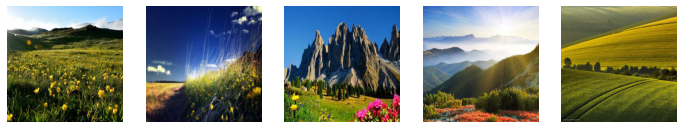

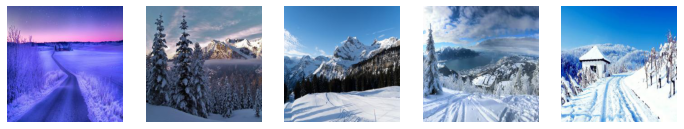

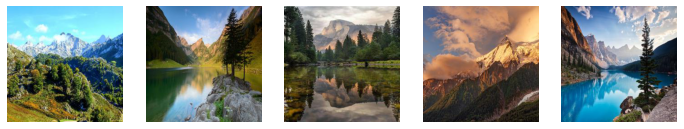

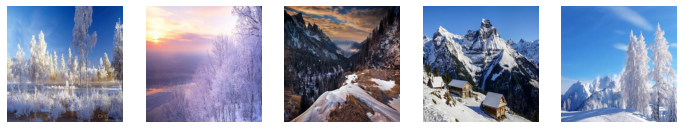

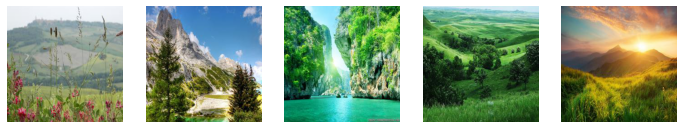

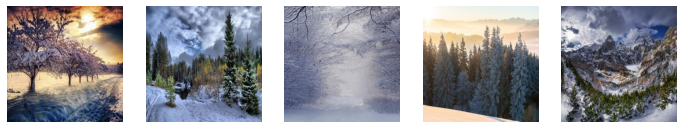

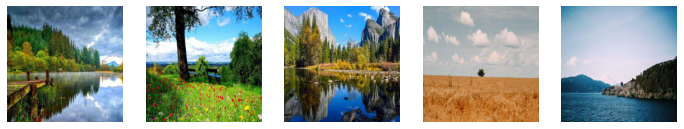

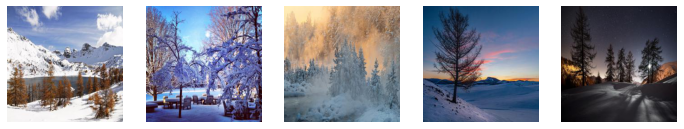

In [34]:
# Load data
dataset = loadSamples('./resizedSeasonDataset/dataAB.npz')
shape = dataset[0].shape[1:]

# models
genA = generator(shape)
genB = generator(shape)
disA = discriminator(shape)
disB = discriminator(shape)
compA = compositeModel(genA, disB, genB, shape)
compB = compositeModel(genB, disA, genA, shape)

# start training
train(disA, disB, genA, genB, compA, compB, dataset)

Save the ultimate model.

In [35]:
def saveModel(gen1, gen2):
    gen1.save('./gen1saved.h5')
    gen2.save('./gen2saved.h5')

saveModel(genA, genB)

# Predicting a new datapoint

In the following, a datapoint is randomly selected from each domain. Then, the two generators are loaded and are used to transform the images respectively. 

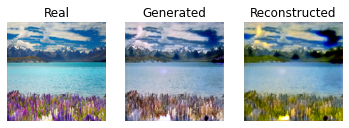

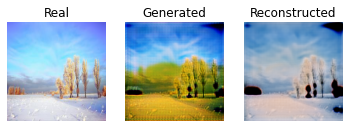

In [36]:
from keras.models import load_model

# Load data
def getRealTestSample(filename):
    # load data
    data = np.load(filename)
    X1, X2 = data['arr_0'], data['arr_1']
    
    # scaling
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    return [X1, X2]
A, B = getRealTestSample('./resizedSeasonDataset/dataAB.npz')

# Load model
theLayer = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('gen1saved.h5', theLayer)
model_BtoA = load_model('gen2saved.h5', theLayer)

# select a sample
def selectData(dataset, num):
    idx = np.random.randint(0, dataset.shape[0], num)
    return dataset[idx]

# Show result
def showResult(imagesX, imagesY1, imagesY2):
    images = np.vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    
    # scale from [-1,1] to [0,1]
    images = (images + 1) / 2.0
    
    # plot
    for i in range(len(images)):
        plt.subplot(1, len(images), 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

# A to B to A
AReal = selectData(A, 1)
BGenerated = model_AtoB.predict(AReal)
ARegenerated = model_BtoA.predict(BGenerated)
showResult(AReal, BGenerated, ARegenerated)

# B to A to B
BReal = selectData(B, 1)
AGenerated = model_BtoA.predict(BReal)
BRegenerated = model_AtoB.predict(AGenerated)
showResult(BReal, AGenerated, BRegenerated)

The first summer sample is taken in South Island, NZ. It can be observed that the summer-to-winter generator transforms the photo by adding white/grey colours to the foreground and the sky. The bright blue colour of the lake is also reduced to a more pale colour. This output is then transformed by the winter-to-summer generator, which applies green colour to the flowers and mountains. 

The second winter sample is more successful in style mapping. The generator, however, mistakens the cloudy sky as mountains and also applies green colour to it. However, in general, the generated and reconstructed photos are quite realistic in appearance.

It is worth mentioning that the generator identifies certain features to apply style (grassland, trees, etc) and others to not apply style/apply other style (lake, sky, etc). This is an exceptional ability of cycleGAN, making this a potentially high-prospect approach for artistic image processing.

In the following, a single generator is used to transform a single datapoint from one domain (summer) to another (winter). It can be observed that, although not perfect, the generator successfully applies winter elements to the photo. It can be postulated that with more epochs of training, the style mapping would be more successful and realistic.

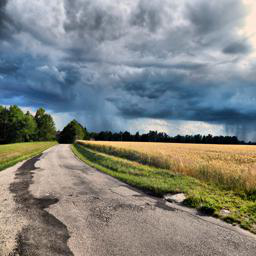

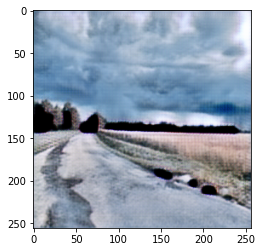

In [44]:
from PIL import Image
from IPython.display import display

def seeImage(src):
    pixels = load_img(src, target_size=(256, 256))
    pixels = img_to_array(pixels)
    pixels = np.expand_dims(pixels, 0)
    pixels = (pixels - 127.5) / 127.5
    return pixels

# load
theImg = seeImage('./resizedSeasonDataset/trainA/24.jpg')
theLayer = {'InstanceNormalization': InstanceNormalization}
model_AtoB = load_model('gen1saved.h5', theLayer)

# See original
orig = Image.open('./resizedSeasonDataset/trainA/24.jpg')
display(orig)

# Transform using generator and see result.
result = model_AtoB.predict(theImg)
result = (result + 1) / 2.0
plt.imshow(result[0])
plt.show()

# Conclusion

Visual arts is of high value to the field of conservation. In this project, a deep learning approach of artivism is explored using cycleGAN, the cycle-consistent generative adversarial networks. With the design of cycle loss, the CycleGAN is designed to apply winter style to summer landscape photos and vice versa. The CycleGAN is trained on web-scraped winter and summer photos, approximately 1000 each, and a Tesla V100 GPU. The networks are implemented in Keras. Although only trained for a limited amount of 30 epochs, the trained networks showed high ability to apply seasonal styles from one domain to another. It is also observed that the trained generators are able to distinguish different features in the photo and apply corresponding colours/styles accordingly. The result thus shows high potential of well-trained cycleGAN in image style mapping, giving it great artistic value in image processing and thus making it a valuable potential approach for environemental artivism.

# Acknowledgement

This notebook is based on the research paper [*Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks*](https://arxiv.org/abs/1703.10593) by Jun-Yan Zhu, et al. and an [article](https://machinelearningmastery.com/cyclegan-tutorial-with-keras/) by Jason Brownlee. Their work is greatly appreciated.